This notebook simulates the effect of spill-back in CMOS detectors. Spill-back occurs during readout of a CMOS detector, when a large enough amount of charge has accumulated on the floating diffusion mode such that the floating diffusion node and transfer gate are equipotential. Some excess charge may then sit on the transfer gate and may "spill back" over to the pinned photodiode when the transfer gate is reset. This leads to image lag and a nonlinear photon transfer curve.

In [146]:
%load_ext autoreload
%autoreload 2

import os
import json
import numpy as np
import copy
import matplotlib.pyplot as plt
from cosmos_helper_funcs import get_stacks, label_plot, cosmos_gain_dict, get_mean_images
from defect_pixel_funcs import *
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
import scipy.interpolate
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Look at COSMOS data

In [3]:
# dark_folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/MKI Lab data/10-5-2024/HSHG_RS/Dark'
# dark_stacks = get_stacks(dark_folder, get_mean_img=True, get_var_img=True, num_imgs=0, datatype='int')
# gray_folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/MKI Lab data/10-5-2024/HSHG_RS/Light'
# gray_stacks = get_stacks(gray_folder, get_mean_img=True, get_var_img=True, num_imgs=0, datatype='int')
# for i, stack in enumerate(dark_stacks):
#     stack['mean_img'] = stack['mean_img'].tolist()
#     stack['var_img'] = stack['var_img'].tolist()
#     # Create file dark_stacks.json if it doesn't exist
# with open('gray_stacks.json', 'w') as f:
#     json.dump(gray_stacks, f)
# with open('dark_stacks.json', 'w') as f:
#     json.dump(dark_stacks, f)


In [4]:
# load dark_stacks.json and gray_stacks.json
dark_stacks = json.load(open('dark_stacks.json'))
gray_stacks = json.load(open('gray_stacks.json'))
# Convert lists to arrays
for i in range(104):
    dark_stacks[i]['mean_img'] = np.array(dark_stacks[i]['mean_img'])
    dark_stacks[i]['var_img'] = np.array(dark_stacks[i]['var_img'])
    gray_stacks[i]['mean_img'] = np.array(gray_stacks[i]['mean_img'])
    gray_stacks[i]['var_img'] = np.array(gray_stacks[i]['var_img'])

In [5]:
# Sort dark_stacks and gray_stacks by exposure time
dark_stacks = sorted(dark_stacks, key=lambda x: float(x['exposure_ms']))
gray_stacks = sorted(gray_stacks, key=lambda x: float(x['exposure_ms']))
exp_times = np.zeros(len(gray_stacks))
mean_list = np.zeros(len(gray_stacks))
gray_list = np.zeros(len(gray_stacks))
var_list = np.zeros(len(gray_stacks))
for i, gray_stack in enumerate(gray_stacks):
    exp_time_ms = float(gray_stack['exposure_ms'])
    gray_list[i] = gray_stack['mean_img_mean']
    mean_val = gray_stack['mean_img_mean'] - dark_stacks[i]['mean_img_mean']
    var_val = gray_stack['var_img_mean'] + dark_stacks[i]['var_img_mean']
    exp_times[i] = exp_time_ms
    mean_list[i] = mean_val
    var_list[i] = var_val

In [6]:
bits = 14
low_lim = np.rint(np.max(mean_list) * 0.05)
high_lim = np.rint(np.max(mean_list) * 0.95)
low_limit_exp_time = np.interp(low_lim, mean_list, exp_times)
high_limit_exp_time = np.interp(high_lim, mean_list, exp_times)
fit_exp_times = exp_times[(mean_list > low_lim) & (mean_list < high_lim)]
fit_mean_list = mean_list[(mean_list > low_lim) & (mean_list < high_lim)]
fit_var_list = var_list[(mean_list > low_lim) & (mean_list < high_lim)]

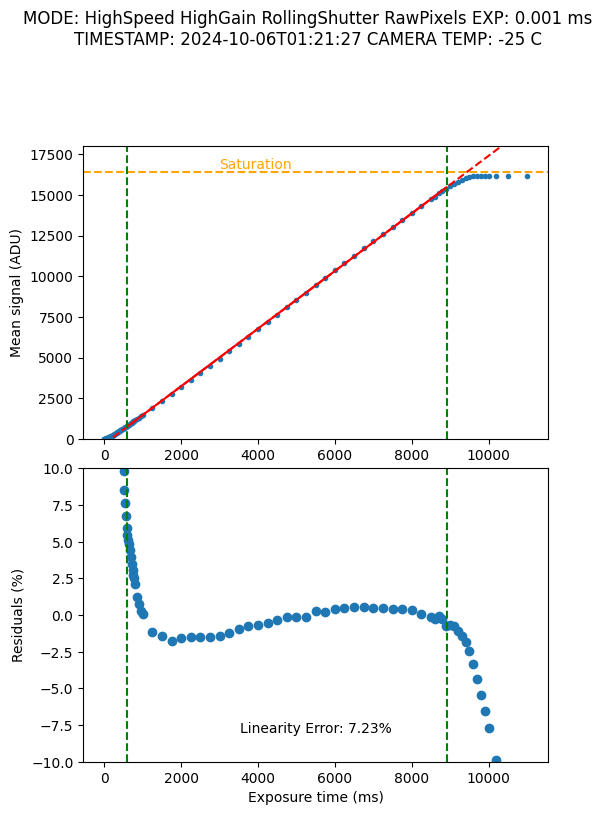

In [25]:
%matplotlib inline
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
ax[0].plot(exp_times, mean_list, 'o', markersize=3)
popt_line, pcov_line = curve_fit(lambda x, a, b: a * x + b, fit_exp_times, fit_mean_list)
ax[0].plot(exp_times, popt_line[0] * exp_times + popt_line[1], c='r', linestyle='--')
ax[0].plot(fit_exp_times, popt_line[0] * fit_exp_times + popt_line[1], c='r')
ax[0].text(0.5, 0.3, f'Slope of fit: {popt_line[0]:.2f}', transform=plt.gca().transAxes)
ax[0].axhline(2**bits - 1, color='orange', linestyle='--')
# Put vertical lines where exposure times intersect low and high limits
ax[0].axvline(low_limit_exp_time, color='g', linestyle='--')
ax[0].axvline(high_limit_exp_time, color='g', linestyle='--')
ax[0].text(3000, 2**bits - 1 + 200, 'Saturation', color='orange')
ax[0].set_ylabel('Mean signal (ADU)')
ax[0].set_ylim(0, 2**bits * 1.1)
label_plot(gray_stacks[0])
# Plot residuals
residuals = (mean_list - popt_line[0] * exp_times - popt_line[1]) / mean_list * 100
ax[1].plot(exp_times, residuals, 'o')
ax[1].axvline(low_limit_exp_time, color='g', linestyle='--')
ax[1].axvline(high_limit_exp_time, color='g', linestyle='--')
ax[1].set_xlabel('Exposure time (ms)')
ax[1].set_ylabel('Residuals (%)')
ax[1].set_ylim(-10, 10)
max_res = np.max(residuals[(exp_times > low_limit_exp_time) & (exp_times < high_limit_exp_time)])
min_res = np.min(residuals[(exp_times > low_limit_exp_time) & (exp_times < high_limit_exp_time)])
linearity_error = max_res - min_res
ax[1].text(0.5, 0.1, f'Linearity Error: {linearity_error:.2f}%', transform=plt.gca().transAxes, ha='center')
# Have axes share x axis
plt.subplots_adjust(hspace=0.1)
plt.show()

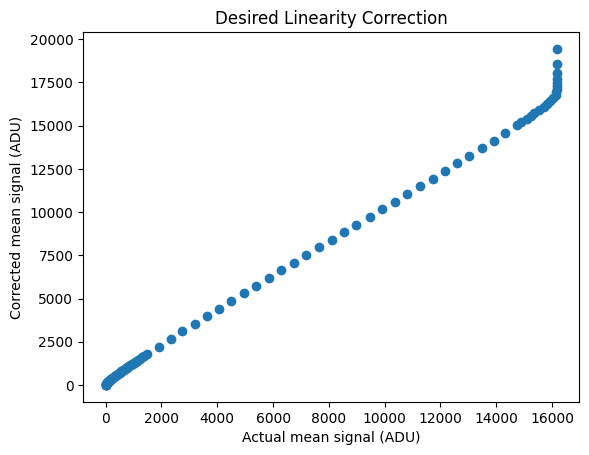

In [381]:
%matplotlib inline
corrected_signal_vals = popt_line[0] * exp_times + popt_line[1]
# We want there to be no negative values in the corrected signal
corrected_signal_vals = corrected_signal_vals - np.min(corrected_signal_vals)
plt.plot(mean_list, corrected_signal_vals, 'o')
plt.xlabel('Actual mean signal (ADU)')
plt.ylabel('Corrected mean signal (ADU)')
plt.title('Desired Linearity Correction')
plt.show()

In [139]:
def poly_func(x, *c_array):
    # Polynomial intersecting the origin
    # return np.polyval(c_array[1:], x) + c_array[0] * x ** 0.5
    return np.polyval(c_array, x) * x
poly_func_vec = np.vectorize(poly_func)
def poly_func2(x, *c_array):
    # Polynomial intersecting the origin
    return x * np.polyval(c_array[1:], x) + c_array[0] * x ** 0.5
    # return np.polyval(c_array, x) * x
poly_func2_vec = np.vectorize(poly_func2)
def rational_func(x, *c_array):
    # Rational function intersecting the origin.
    top_coeff_array = c_array[:len(c_array) // 2]
    bottom_coeff_array = c_array[len(c_array) // 2:]
    return (np.polyval(top_coeff_array, x)) / (np.polyval(bottom_coeff_array, x))
rational_func_vec = np.vectorize(rational_func)
def power_law_func(x, *c_array):
    coefficients = np.array(c_array[:len(c_array) // 2])
    exponents = np.array(c_array[len(c_array) // 2:])
    # Exponents must be greater than 0
    exponents = np.abs(exponents)
    return np.sum(coefficients * x ** exponents)
power_law_func_vec = np.vectorize(power_law_func)
def piecewise_poly_func(x, *c_array, cutoff=4000):
    # Piecewise polynomial function
    if x < cutoff:
        return np.polyval(c_array[:len(c_array) // 2], x)
    else:
        return np.polyval(c_array[len(c_array) // 2:], x)
piecewise_poly_func_vec = np.vectorize(piecewise_poly_func)

In [29]:
%matplotlib qt
# Fit mean_list vs corrected_signal_vals to a polynomial fit. Plot residuals
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(15)
p0 = np.zeros(12)
p0_high = np.zeros(12)
# The index above which mean_list is greater than 1600
cutoff_idx = np.argmax(mean_list > 1000)
cutoff_value = mean_list[cutoff_idx-1]
print(mean_list[cutoff_idx])
high_cutoff_idx = np.argmax(mean_list > 15000)
high_cutoff_value = mean_list[high_cutoff_idx]
popt_poly, pcov_poly = curve_fit(poly_func, mean_list[:cutoff_idx], corrected_signal_vals[:cutoff_idx], p0=p0, maxfev=10000)
popt_poly_high, pcov_poly_high = curve_fit(poly_func, mean_list[cutoff_idx-1:high_cutoff_idx], corrected_signal_vals[cutoff_idx-1:high_cutoff_idx], p0=p0_high, maxfev=10000)
residuals_poly = (corrected_signal_vals[:cutoff_idx] - poly_func(mean_list[:cutoff_idx], *popt_poly))
residuals_poly_high = (corrected_signal_vals[cutoff_idx-1:high_cutoff_idx] - poly_func(mean_list[cutoff_idx-1:high_cutoff_idx], *popt_poly_high))
ax[0].plot(mean_list[:cutoff_idx], corrected_signal_vals[:cutoff_idx], 'bo', markersize=2,)
ax[0].plot(mean_list[cutoff_idx-1:high_cutoff_idx], corrected_signal_vals[cutoff_idx-1:high_cutoff_idx], 'ro', markersize=2)
low_signal_vals = np.arange(0, cutoff_value, 1)
high_signal_vals = np.arange(cutoff_value, high_cutoff_value, 1)
ax[0].plot(low_signal_vals, poly_func(low_signal_vals, *popt_poly), 'blue')
ax[0].plot(high_signal_vals, poly_func(high_signal_vals, *popt_poly_high), 'r')
ax[0].set_xlabel('Actual mean signal (ADU)')
ax[0].set_ylabel('Corrected mean signal (ADU)')
ax[0].set_title('Polynomial Fit')
ax[1].plot(mean_list[:cutoff_idx], residuals_poly[:cutoff_idx], 'bo', markersize=2)
ax[1].plot(mean_list[cutoff_idx-1:high_cutoff_idx], residuals_poly_high, 'ro', markersize=2)
ax[1].set_xlabel('Actual mean signal (ADU)')
ax[1].set_ylabel('Residuals')
ax[1].set_title('Polynomial Fit Residuals')
residuals_percent = residuals_poly / corrected_signal_vals[:cutoff_idx] * 100
residuals_percent_high = residuals_poly_high / corrected_signal_vals[cutoff_idx-1:high_cutoff_idx] * 100
ax[2].plot(mean_list[:cutoff_idx], residuals_percent, 'bo', markersize=2)
ax[2].plot(mean_list[cutoff_idx-1:high_cutoff_idx], residuals_percent_high, 'ro', markersize=2)
ax[2].set_xlabel('Actual mean signal (ADU)')
ax[2].set_ylabel('Residuals (%)')
plt.show()
print(popt_poly)

1014.348111683734
[ 6.96360136e-31 -2.27660555e-27 -3.47844435e-26  1.12186631e-20
 -2.42343421e-17  2.64509995e-14 -1.75365479e-11  7.41173108e-09
 -1.99800025e-06  3.33962082e-04 -3.35847484e-02  3.41222009e+00]


/var/folders/vx/4cbfv3l120sgd531_rn7rsj40000gn/T/ipykernel_74595/33324916.py:31: RuntimeWarning: divide by zero encountered in divide
  residuals_percent = residuals_poly / corrected_signal_vals[:cutoff_idx] * 100


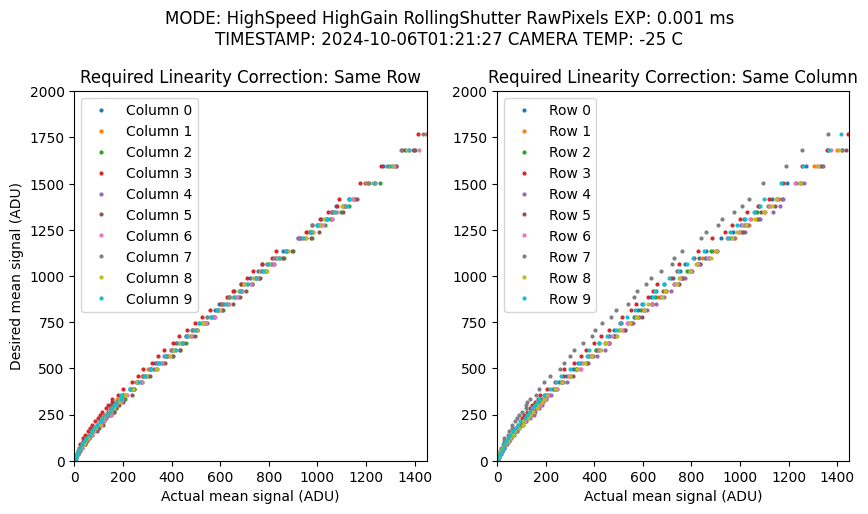

In [19]:
%matplotlib inline
# See whether we need to do a correction for every individual pixel
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(10)
# Try to do a basic flat-field correction to line up the points
middle_signal_vals_reference = [(gray_stacks[i]['mean_img'][0,0] - dark_stacks[i]['mean_img'][0,0]) for i in range(60,65)]
for i in range(10):
    gray_signal_vals = [stack['mean_img'][0, i] for stack in gray_stacks]
    dark_signal_vals = [stack['mean_img'][0,i] for stack in dark_stacks]
    mean_vals = np.array(gray_signal_vals) - np.array(dark_signal_vals)
    middle_signal_vals = mean_vals[60:65]
    mean_vals = mean_vals * np.mean(middle_signal_vals_reference) / np.mean(middle_signal_vals)
    ax[0].plot(mean_vals, corrected_signal_vals, 'o', markersize=2, label=f'Column {i}')
    ax[0].set_xlabel('Actual mean signal (ADU)')
    ax[0].set_ylabel('Desired mean signal (ADU)')
    ax[0].set_title('Required Linearity Correction: Same Row')
    ax[0].legend()
    ax[0].set_xlim(0, 1450)
    ax[0].set_ylim(0, 2000)
    gray_signal_vals = [stack['mean_img'][i, 0] for stack in gray_stacks]
    dark_signal_vals = [stack['mean_img'][i, 0] for stack in dark_stacks]
    mean_vals = np.array(gray_signal_vals) - np.array(dark_signal_vals)
    ax[1].plot(mean_vals, corrected_signal_vals, 'o', markersize=2, label=f'Row {i}')
    ax[1].set_xlabel('Actual mean signal (ADU)')
    ax[1].set_title('Required Linearity Correction: Same Column')
    ax[1].legend()
    ax[1].set_xlim(0, 1450)
    ax[1].set_ylim(0, 2000)
label_plot(gray_stacks[0])
plt.show()

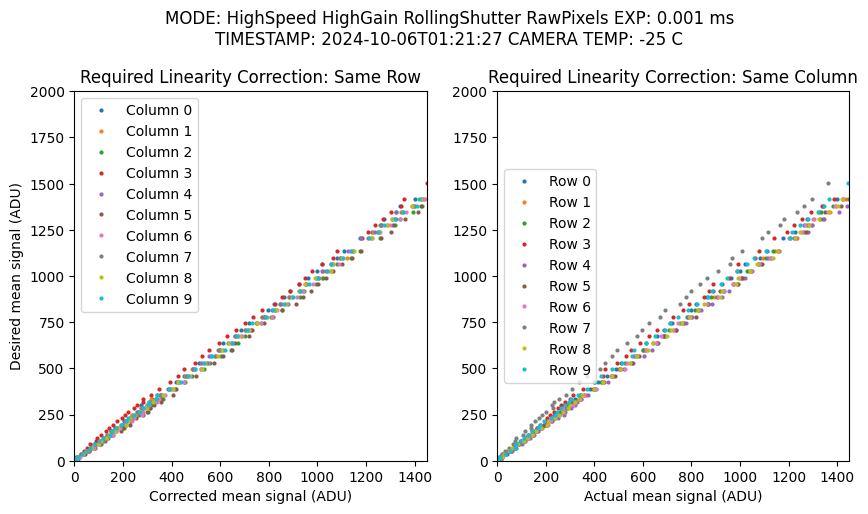

In [24]:
%matplotlib inline
poly_coefficients = np.array([-1.11332005e-31, 9.83489385e-28, -3.83481258e-24,  8.69244319e-21,
                              -1.26915294e-17, 1.24869164e-14, -8.40577356e-12,  3.84719377e-09,
                              -1.16671178e-06, 2.24630045e-04, -2.65071660e-02,  3.25187633e+00])
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(10)
middle_signal_vals_reference = np.array([(gray_stacks[i]['mean_img'][0,0] - dark_stacks[i]['mean_img'][0,0]) for i in range(10,20)])
middle_signal_vals_reference = np.polyval(poly_coefficients, middle_signal_vals_reference) * middle_signal_vals_reference
for i in range(10):
    gray_signal_vals = [stack['mean_img'][0, i] for stack in gray_stacks]
    dark_signal_vals = [stack['mean_img'][0,i] for stack in dark_stacks]
    mean_vals = np.array(gray_signal_vals) - np.array(dark_signal_vals)
    corrected_mean_vals = np.polyval(poly_coefficients, mean_vals) * mean_vals
    # corrected_mean_vals = corrected_mean_vals * np.mean(middle_signal_vals_reference) / np.mean(corrected_mean_vals[10:20])
    ax[0].plot(corrected_mean_vals, corrected_signal_vals, 'o', markersize=2, label=f'Column {i}')
    ax[0].set_xlabel('Corrected mean signal (ADU)')
    ax[0].set_ylabel('Desired mean signal (ADU)')
    ax[0].set_title('Required Linearity Correction: Same Row')
    ax[0].legend()
    ax[0].set_xlim(0, 1450)
    ax[0].set_ylim(0, 2000)
    gray_signal_vals = [stack['mean_img'][i, 0] for stack in gray_stacks]
    dark_signal_vals = [stack['mean_img'][i, 0] for stack in dark_stacks]
    mean_vals = np.array(gray_signal_vals) - np.array(dark_signal_vals)
    corrected_mean_vals = np.polyval(poly_coefficients, mean_vals) * mean_vals
    # corrected_mean_vals = corrected_mean_vals * np.mean(middle_signal_vals_reference) / np.mean(corrected_mean_vals[10:20])
    ax[1].plot(corrected_mean_vals, corrected_signal_vals, 'o', markersize=2, label=f'Row {i}')
    ax[1].set_xlabel('Actual mean signal (ADU)')
    ax[1].set_title('Required Linearity Correction: Same Column')
    ax[1].legend()
    ax[1].set_xlim(0, 1450)
    ax[1].set_ylim(0, 2000)
label_plot(gray_stacks[0])
plt.show()

Indeed, it is necessary to do totally separate nonlinearity corrections for every pixel. Even a flat field correction does not line the curves up. And you cannot just use a correction for each row or each pixel. Even directly adjacent pixels can be very different.

In [87]:
print(mean_list[10])

63.817495450023074


In [391]:
raw_images = np.array([stack['mean_img'] for stack in gray_stacks])
dark_images = np.array([stack['mean_img'] for stack in dark_stacks])
subtracted_images = raw_images - dark_images

In [395]:
%matplotlib qt
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(15)
coeff_array = np.zeros((100, 100, 20))
for i in range(100):
    for j in range(100):
        mean_vals = subtracted_images[:, i, j]
        # Set any negative values to zero
        # mean_vals[mean_vals < 0] = 0
        # # Throw out points where the mean value is not smaller than the next mean value
        # mean_vals_good_idx = mean_vals <= np.roll(mean_vals, -1)
        # mean_vals = mean_vals[mean_vals_good_idx]
        # corrected_signal_vals_pixel = copy.copy(corrected_signal_vals)#[mean_vals_good_idx])
        cutoff_idx = np.argmax(mean_vals > 1000)
        cutoff_value = mean_vals[cutoff_idx-1]
        high_cutoff_idx = np.argmax(mean_vals > 16000)
        high_cutoff_value = mean_vals[high_cutoff_idx]
        weights = np.ones_like(mean_vals[:cutoff_idx+2])
        # if mean_vals[0] == 0:
        #     weights[0] = 10
        # popt_poly, pcov_poly = curve_fit(poly_func, mean_vals[:cutoff_idx+2], corrected_signal_vals[:cutoff_idx+2], p0=p0_low, maxfev=10000)
        popt_poly = np.polyfit(mean_vals[:cutoff_idx+2], corrected_signal_vals[:cutoff_idx+2], deg=9, w=weights)
        popt_poly_high = np.polyfit(mean_vals[cutoff_idx-1:high_cutoff_idx+2], corrected_signal_vals[cutoff_idx-1:high_cutoff_idx+2], deg=9)
        # Add 6 zeros to the start of popt_poly_high to match the length of popt_poly
        coeff_array[i, j] = np.concatenate((popt_poly, popt_poly_high))
        residuals_poly = corrected_signal_vals[:cutoff_idx+2] - np.polyval(popt_poly, mean_vals[:cutoff_idx+2])
        residuals_poly_high = corrected_signal_vals[cutoff_idx-1:high_cutoff_idx+2] - np.polyval(popt_poly_high, mean_vals[cutoff_idx-1:high_cutoff_idx+2])
        residuals_poly_percent = residuals_poly / corrected_signal_vals[:cutoff_idx+2] * 100
        residuals_poly_percent_high = residuals_poly_high / corrected_signal_vals[cutoff_idx-1:high_cutoff_idx+2] * 100
        low_vals_plot = np.arange(0, 1000, 0.5)
        high_vals_plot = np.arange(1000, 16000, 0.5)
        if i == 0 and j < 11:
            ax[0].plot(mean_vals, corrected_signal_vals, 'o', markersize=2, label=f'Pixel {i}, {j}')
            ax[0].plot(low_vals_plot, np.polyval(popt_poly, low_vals_plot), c=ax[0].lines[-1].get_color())
            ax[0].plot(high_vals_plot, np.polyval(popt_poly_high, high_vals_plot), c=ax[0].lines[-1].get_color())
            ax[1].plot(mean_vals[:cutoff_idx+2], residuals_poly, 'o', markersize=1, c=ax[0].lines[-1].get_color())
            ax[1].plot(mean_vals[cutoff_idx-1:high_cutoff_idx+2], residuals_poly_high, 'o', markersize=1, c=ax[0].lines[-1].get_color())
            ax[2].plot(mean_vals[:cutoff_idx+2], residuals_poly_percent, 'o', markersize=1, c=ax[0].lines[-1].get_color())
            ax[2].plot(mean_vals[cutoff_idx-1:high_cutoff_idx+2], residuals_poly_percent_high, 'o', markersize=1, c=ax[0].lines[-1].get_color())
        # print(corrected_signal_vals[:cutoff_idx], np.polyval(popt_poly, mean_vals[:cutoff_idx]) * mean_vals[:cutoff_idx])
        # # Handle duplicates in mean_vals by averaging the corresponding corrected_signal_vals
        # mean_vals, indices = np.unique(mean_vals, return_inverse=True)
        # corrected_signal_vals_pixel = np.bincount(indices, weights=corrected_signal_vals_pixel) / np.bincount(indices)
        # corrected_signal_vals_fit = corrected_signal_vals_pixel[:90]
        # mean_vals_fit = mean_vals[:90]
        # mean_vals_fit_plot = np.arange(0, 15000, 1)
        # ax[0].plot(mean_vals, corrected_signal_vals_pixel, 'o', markersize=2, label=f'Pixel {i}, {j}')
        # Create a linear interpolation to fit data
        # interp_func = scipy.interpolate.interp1d(mean_vals_fit, corrected_signal_vals_fit, kind='linear', fill_value='extrapolate')
        # ax[0].plot(mean_vals_fit_plot, interp_func(mean_vals_fit_plot), c=ax[0].lines[-1].get_color())
        # Create a polynomial fit to the data
        # p0 = np.array([0, 0, 1, -500, 1, 0.3])
        # popt, pcov = curve_fit(poly_func_vec, mean_vals_fit, corrected_signal_vals_fit, p0=p0, maxfev=10000)
        # ax[0].plot(mean_vals_fit_plot, poly_func_vec(mean_vals_fit_plot, *popt), c=ax[0].lines[-1].get_color())
        # Create a rational fit to the data
        # p0[len(p0) // 2 - 1] = -500
        # p0[len(p0) // 2:] = 1
        # popt, pcov = curve_fit(rational_func, mean_vals_fit, corrected_signal_vals_fit, p0=p0, maxfev=10000)
        # ax[0].plot(mean_vals_fit_plot, rational_func_vec(mean_vals_fit_plot, *popt), c=ax[0].lines[-1].get_color())
        # # Find roots of the denominator polynomial
        # roots = np.roots(popt[len(popt) // 2:])
        # Print any roots within the dynamic range of the sensor
        # print(i, j)
        # for root in roots:
        #     if np.isreal(root) and np.real(root) > 0 and np.real(root) < 2 ** bits:
        #         print(root)
        # print()
        # Create a sum of power laws fit to the data
        # p0 = np.array([-400,1,1,0,0.5,1])
        # popt, pcov = curve_fit(power_law_func_vec, mean_vals_fit, corrected_signal_vals_fit, p0=p0, maxfev=10000)
        # ax[0].plot(mean_vals_fit_plot, power_law_func_vec(mean_vals_fit_plot, *popt), c=ax[0].lines[-1].get_color())
        # Create cubic splines to fit data
        # cs = CubicSpline(mean_vals_fit, corrected_signal_vals_fit)
        # ax[0].plot(mean_vals_fit_plot, cs(mean_vals_fit_plot), c=ax[0].lines[-1].get_color())

        # Plot residuals
        # residuals = corrected_signal_vals_fit - poly_func_vec(mean_vals_fit, *popt)
        # residuals = corrected_signal_vals_fit - rational_func_vec(mean_vals_fit, *popt)
        # residuals = corrected_signal_vals_fit - cs(mean_vals_fit)
        # residuals = corrected_signal_vals_fit - power_law_func_vec(mean_vals_fit, *popt)
        # percent_residuals = residuals / corrected_signal_vals_fit * 100
        # ax[1].plot(mean_vals_fit, residuals, 'o', markersize=2)
        # ax[1].plot(mean_vals_fit_plot, np.sqrt(mean_vals_fit_plot / 11), c='r', linestyle='--')
        # ax[1].plot(mean_vals_fit_plot, -np.sqrt(mean_vals_fit_plot / 11), c='r', linestyle='--')
        # ax[2].plot(mean_vals_fit, percent_residuals, 'o', markersize=2)
        # ax[2].plot(mean_vals_fit_plot, np.sqrt(1 / mean_vals_fit_plot / 11) * 100, c='r', linestyle='--')
        # ax[2].plot(mean_vals_fit_plot, -np.sqrt(1 / mean_vals_fit_plot / 11) * 100, c='r', linestyle='--')

ax[0].legend()
ax[0].set_xlabel('Mean Pixel Signal (ADU)')
ax[0].set_ylabel('Corrected Mean Pixel Signal (ADU)')
# ax[1].set_xlabel('Exposure time (ms)')
ax[1].set_xlabel('Mean signal (ADU)')
ax[1].set_ylabel('Residuals of Fit (Adu)')
ax[1].set_ylim(-100, 100)
ax[2].set_xlabel('Mean signal (ADU)')
ax[2].set_ylabel('Residuals of Fit (%)')
ax[2].set_ylim(-100, 100)
label_plot(gray_stacks[0])
plt.show()

/var/folders/vx/4cbfv3l120sgd531_rn7rsj40000gn/T/ipykernel_74595/2655546516.py:28: RuntimeWarning: divide by zero encountered in divide
  residuals_poly_percent = residuals_poly / corrected_signal_vals[:cutoff_idx+2] * 100


In [397]:
%matplotlib qt
# Use the coefficents to correct the images
def correct_images(image_stack, coeffs):
    corrected_stack = np.zeros_like(image_stack, dtype=float)
    for i, frame in enumerate(image_stack):
        corrected_frame = np.zeros_like(frame, dtype=float)
        low_vals_frame = np.zeros_like(frame)
        low_vals_frame[frame <= 1000] = frame[frame <= 1000]
        high_vals_frame = np.zeros_like(frame)
        # Select only elements between 1000 and 16000
        high_vals_frame[(frame > 1000) & (frame < 16000)] = frame[(frame > 1000) & (frame < 16000)]
        high_vals_true_frame = np.zeros_like(frame)
        high_vals_true_frame = (frame > 1000) & (frame < 16000)
        saturated_vals_true_frame = frame >= 16000
        for j in range(10):
            corrected_frame += coeffs[:,:, j] * low_vals_frame.astype(float) ** (9 - j)
        for j in range(10):
            corrected_frame += coeffs[:,:,j+10] * high_vals_frame.astype(float) ** (9 - j)
            # For saturated values, set the corrected value to the correction of 16000 ADU
            corrected_frame += coeffs[:,:,j+10] * (16000 * saturated_vals_true_frame).astype(float) ** (9 - j)
        # Only add the constant term for the high fit if the value is high
        corrected_frame += coeffs[:,:,19] * high_vals_true_frame
        corrected_frame += coeffs[:,:,19] * saturated_vals_true_frame
        corrected_stack[i] = corrected_frame
    return np.rint(corrected_stack).astype(int)
        
t0 = time.time()
corrected_images = correct_images(subtracted_images[:], coeff_array)
print(corrected_images[0])
print(time.time() - t0)
for i in range(100):
    plt.plot(subtracted_images[:,i,0], corrected_images[:, i, 0], 'o', markersize=2)
    # plt.plot(exp_times, corrected_images[:, i, 0], 'o', markersize=2)
plt.show()


[[ -294   413  -373 ...  -356   184 -1214]
 [ -782  -622  -658 ...    70  -357  -125]
 [  107  -315 -1095 ...  -194    30  -390]
 ...
 [ -444  -514  -266 ...  -599    39    25]
 [ -426 -1552   122 ...    23    68  -864]
 [  641   425  -463 ...  -819  -222  -127]]
0.30573415756225586


In [359]:
%matplotlib qt
mean_corrected_vals = np.mean(corrected_images, axis=(1,2))
low_lim = np.rint(np.max(mean_corrected_vals) * 0.05)
high_lim = np.rint(np.max(mean_corrected_vals) * 0.95)
low_limit_exp_time = np.interp(low_lim, mean_corrected_vals, exp_times)
high_limit_exp_time = np.interp(high_lim, mean_corrected_vals, exp_times)
fit_exp_times = exp_times[(mean_corrected_vals > low_lim) & (mean_corrected_vals < high_lim)]
fit_corrected_mean_vals = mean_corrected_vals[(mean_corrected_vals > low_lim) & (mean_corrected_vals < high_lim)]
fit_corrected_vals = mean_corrected_vals[(mean_corrected_vals > low_lim) & (mean_corrected_vals < high_lim)]
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
ax[0].plot(exp_times, mean_corrected_vals, 'o', markersize=3)
popt_line, pcov_line = curve_fit(lambda x, a, b: a * x + b, fit_exp_times, fit_corrected_vals)
# ax[0].plot(exp_times, popt_line[0] * exp_times + popt_line[1], c='r', linestyle='--')
# ax[0].plot(fit_exp_times, popt_line[0] * fit_exp_times + popt_line[1], c='r')
ax[0].text(0.5, 0.3, f'Slope of fit: {popt_line[0]:.2f}', transform=plt.gca().transAxes)
ax[0].axhline(2**bits - 1, color='orange', linestyle='--')
# Put vertical lines where exposure times intersect low and high limits
ax[0].axvline(low_limit_exp_time, color='g', linestyle='--')
ax[0].axvline(high_limit_exp_time, color='g', linestyle='--')
ax[0].text(3000, 2**bits - 1 + 200, 'Saturation', color='orange')
ax[0].set_ylabel('Mean Corrected Signal (ADU)')
ax[0].set_ylim(0, 2**bits * 1.1)
label_plot(gray_stacks[0])
# Plot residuals
residuals = (mean_corrected_vals - popt_line[0] * exp_times - popt_line[1]) / mean_list * 100
ax[1].plot(exp_times, residuals, 'o')
ax[1].axvline(low_limit_exp_time, color='g', linestyle='--')
ax[1].axvline(high_limit_exp_time, color='g', linestyle='--')
ax[1].set_xlabel('Exposure time (ms)')
ax[1].set_ylabel('Residuals (%)')
ax[1].set_ylim(-10, 10)
max_res = np.max(residuals[(exp_times > low_limit_exp_time) & (exp_times < high_limit_exp_time)])
min_res = np.min(residuals[(exp_times > low_limit_exp_time) & (exp_times < high_limit_exp_time)])
linearity_error = max_res - min_res
ax[1].text(0.5, 0.1, f'Linearity Error: {linearity_error:.2f}%', transform=plt.gca().transAxes, ha='center')
# Have axes share x axis
plt.subplots_adjust(hspace=0.1)
plt.show()

Want to create a calibration so that we can go from measured signal (ADU) to number of photoelectrons, using our data of measured signal vs. exposure time and our Cd-109 x-ray data. From the x-ray data, we know that on average, for the 22.103 keV line that produces 22103/3.66=6039 photoelectrons, we saw a mean measured signal of 5915 ADU for the HS_HG_RS mode.

Therefore, if we interpolate to find the exposure time that yields an average of 5915 ADU for the HS_HG_RS, then we can say that this exposure time corresponds to 6039 photoelectrons, and we can calibrate the exposure time values to number of photoelectrons (since they are proportional).

Note: it takes ~1 second to take an image to a power greater than 2. Maybe faster on GPUs? Otherwise we really can't do the calibration in real-time with a high-order polynomial (or rational fit).

Yes, with my GPU on my home PC, it takes ~0.5 ms to do this exponentiation. So our calibration procedure is going to have to rely on using GPUs.

A few notes on various nonlinear calibration techniques:
- Polynomial fits: even at high order, don't do a good job of capturing low-signal response. Easy to implement and fast on GPUs.
- Polynomial fits with square root/power law: more complicated, better than polynomial, but still not great for low signal levels
- Rational fits: do better at capturing low-signal response, but have the potential to produce roots in the demoninator that make the calibrated number of photoelectrons go to infinity
- Cubic Splines: obviously fit the data exactly, but introduce many areas of the parameter space of signal levels where increasing signal levels calibrate to decreasing photoelectron value (cubic splines are not monotonic). A bit more complicated to implement on a GPU (can think of cubic splines for one pixel as O(100) separate cubic polynomials), but it's manageable.
- Linear Interpolation: like cubic splines, calibration is more complicated to implement on GPU, but a little less demanding. Will naturally fit the calibration data exactly, and will always be monotonically increasing, assuming the calibration data is.

In [157]:
x = np.array([1, 2, 3])
10 ** x

array([  10,  100, 1000])